

OK: - loops v/s list comprehensions


Basic use of SageMath: 
-  How to use Sage: coercion
-  Symbolic expressions: solve equations,  
-  
-  
- Linear algebra: over exact rings v/s over reals or complex numbers, using numpy for numerical linear algebra
- Basic combinatorics: partitions, random elements

    
    
    
    

## For Lesson 1

In [37]:
x=RealField(3.32*227).pi().exp()
s=f"e^pi={x}"
print(s)

e^pi=23.14069263277926900572908636794854738026610624260021199344504640952434235069045278351697199706754921967595270480108777314442804441469383584471744587960984936532796586366924223026899101374176468440141039518386847724306805958816


In [38]:
len(s)-7

225

## For lesson 2

In [42]:
def zeta_v1(s, eps=1e-5):
    r"""
    Compute the Riemann zeta function.
    
    INPUT:
    
    - `s` -- complex number, argument
    - `eps` -- real number, desired error estimate
    
    OUTPUT: complex number of same type as input
    """
    if not isinstance(s,sage.rings.complex_number.ComplexNumber):
        raise ValueError("Need a complex number!")
    if s.real() <= 1:
        raise ValueError("Complex number need ot have real part greater than 1")
    # Crude error bound, simply estimating the last term
    nmax = ceil(eps**(-1/s.real()))
    return sum([s.parent()(n)**(-s) for n in range(1,nmax)])
    
    

In [43]:
zeta_v1(CC(3),eps=1e-10) - CC(zeta(3))

-1.07715197428249e-7

In [44]:
zeta_v1(CC(2,1))

1.14819638365843 - 0.436957509976529*I

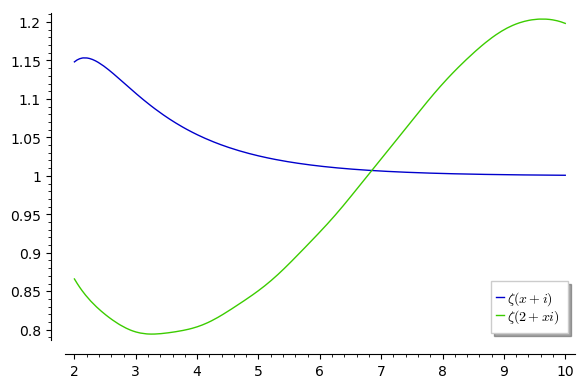

In [45]:
plot([lambda x: zeta_v1(CC(x,1)).real(),lambda x: zeta_v1(CC(2,x)).real()] ,2,10, legend_label=['$\\zeta(x+i)$',r'$\zeta(2+xi)$'])

## Lesson 3

In [62]:
var('x','t')
F =  t*e**(x*t)/(e**t -1); F

t*e^(t*x)/(e^t - 1)

In [64]:
F.taylor(t,0,1).coefficient(t)

x - 1/2

In [78]:
def Bernoulli_pol(k):
    return factorial(k)*F.taylor(t,0,k).coefficient(t**k)
    

In [81]:
[ Bernoulli_pol(k) - bernoulli_polynomial(x,k) for k in range(2,50,2)] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [82]:
%timeit Bernoulli_pol(10)

100 loops, best of 5: 5.63 ms per loop


In [83]:
%timeit bernoulli_polynomial(x,10)

10000 loops, best of 5: 119 µs per loop


In [ ]:
# Lesson 4

To check on the Riemann Hypothesis we need to be able to evaluate $\zeta$ to the left of the real part = 1.
We can not rely on the definition as a sum here but need to use a method of analytic continuation. For instance using the Euler Mc Laurin Formula for $\zeta$.
Letting $f(n)=n^{-s}$, $a=1$ and $b=\infty$. If $\Re(s)>1$:

$$
\zeta(s) = \sum_{n=1}^{\infty} n^{-s} = -\frac{1}{1-s}  
- \Sigma_{j=1}^{k}\frac{(-1)^{j-1}(s)_{j-1} B_{j} }{(j)!}
+ \frac{(-1)^{k-1}(-1)^{k}(s)_k}{(k)!} \int_{1}^{\infty} B_{k}(x-[x])x^{-s-k}(x) dx.
$$

where $(s)_k = s(s+1)\cdots (s+k-1)$ is the **Pochhammer** symbol:
$$
 (s)_{k} = \frac{\Gamma(s+k)}{\Gamma(s)}
$$
Observe that the Right-hand side is convergent for $\Re(s)>1-k$.
We are now ready to try out the Euler McLaurin

In [116]:
def pochammer(s,j):
    return gamma(s+j)/gamma(s)

def zeta_euler_mclaurin(s,k,a=10):
    F = s.parent()
    ca = F(a)
    term0 = sum([F(n)**-s for n in range(1,a)])
    term1 = 1/(s-1)*F(a)**(1-s)
    term2 = 1/2*F(a)**-s
    term3 = sum([(-1)**(j-1)*pochammer(s,j-1)*bernoulli(j)/factorial(j)*ca**(-s-j+1) for j in range(2,k+1)])
#    print(term1,term2,term3)
    return term0 + term1 + term2 - term3
    
    
    

In [117]:
CF=ComplexField(53)
diffs = [lambda t: abs(zeta_euler_mclaurin(CF(0,t),50,a=k) - CF(zeta(CF(0,t)))) for k in range(10,20,2)]

In [ ]:
plot([diffs[0],diffs[4]],1,5)

5

In [86]:
def bernoulli_recursive(k):
    if k==0:
        return 1
    return -sum([binomial(k,j)*bernoulli_recursive(j)/(k-j+1) for j in range(0,k)])

In [87]:
[bernoulli_recursive(k) for k in range(10)]

[1, -1/2, 1/6, 0, -1/30, 0, 1/42, 0, -1/30, 0]

Examples for Lesson 5

In [115]:
class ZetaNumerical(SageObject):
    r"""
    Class to compute the Riemann zeta function.
    """
    def __init__(self,prec=53, maxn=100): #  'dunder' init function
        """
        
        """
        # define some "private" properties
        self._prec = prec
        self._base_ring = ComplexField(prec)
        self._maxn = maxn

    # convencience methods for accessing (not modifying) private variables
    def prec(self):
        r"""
        Return precision of self.
        """
        return self._prec
    
    def base_ring(self):
        r"""
        Return the base ring of self.
        """
        return self._base_ring
    
    
    def __call__(self,s): ##  'dunder' call function used when class element is "called"
        #
        # The 'r' in front of """ means that this is a "raw" string, otherwise there 
        # would have been an error from the '\z' here. 
        r"""
        Evaluate \zeta(s)
        
        INPUT:
        
        - ``s`` -- complex number
        
        
        EXAMPLE:
        
        sage: z = ZetaNumerical(103)
        sage: z(10)
        ...
        sage: z(x)
        ...
        """
        try: 
            scplx = self._base_ring(s)
        except TypeError: # Type error is raised when an internal function can not apply on this type
            raise ValueError(f"Could not coerce {z} to a complex number!")
        if scplx.real() > 1:
            return self._sum(scplx)
        return self._euler_mclaurin(scplx)
    
    # Private method starting with '_'. 
    # Should not be called explicitly from outside this class
    def _sum(self,s):
        r"""
        Evaluate self using a "naive" sum.
        """
        return sum([self._base_ring(n)**-s for n in range(1,self._maxn)])
    
    def _euler_mclaurin(self,s):
        r"""
        Evaluate self using the Euler McLaurin summation formula.
        """
        # When writing a class it is useful to populate it with methods you would like
        # and then simply mark these as 
        raise NotImplementedError("This method has not been implemented yet!")
    def __repr__(self):
        """
        String representation of self.
        """
        return f"NumericalZ with precision {self._prec}"
    
    def plot_along_vertical(self,x,ylim,num_points=100):
        """
        Plot zeta along on a vertical line.
        
        INPUT:
        
        - ``x`` -- real number, the x-coordinate of the lin
        - ``ylim`` -- tuple (a,b) with a<b, endpoint of the vertical line
        - ``num_points`` -- integer (default=100), numer of points to use in the plot
        """
        try: 
            a,b = ylim
        except TypeError:
            raise ValueError("Limits must be  tuple!")
        if a >= b:
            raise ValueError("Endpoints (a,b) must satisfy a<b")
        return parametric_plot((lambda t:self(CC(x,t)).real(),lambda t:Z(CC(x,t)).imag()),(t,a,b))


In [116]:
Z=ZetaNumerical();Z

NumericalZ with precision 53

In [117]:
str(Z)

'NumericalZ with precision 53'

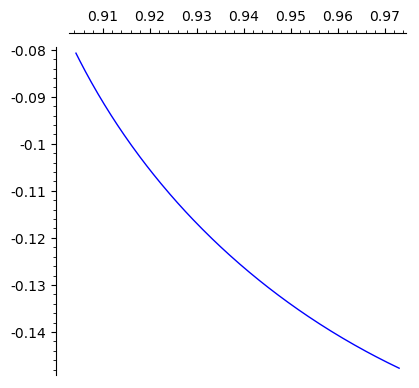

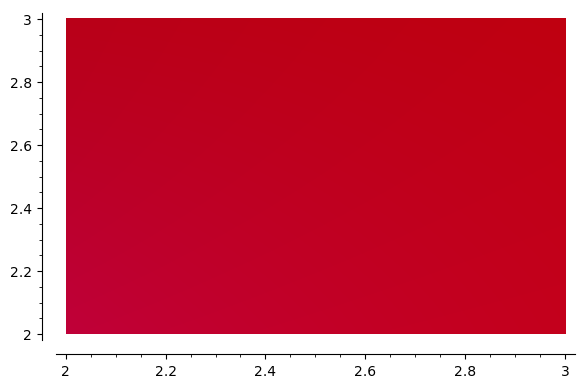

In [118]:
Z.plot_vertical(2,(2,3))

Examples for Lesson 6

In [139]:
var('x','y')
plot3d(lambda x,y: abs(zeta(CF(x,y))) if (x,y)!=(1,0) else 0,(x,-9,9),(y,2,20))

Graphics3d Object

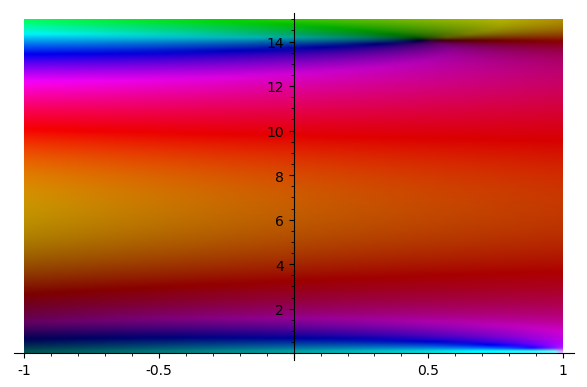

In [149]:
complex_plot(lambda z: zeta(z),(-1,1),(.001,15))

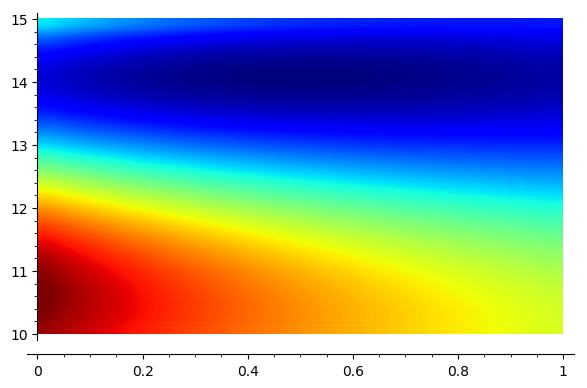

In [150]:
p3=density_plot(lambda x,y: abs(zeta(CC(x,y)))**2,(x,0,1),(y,10,15),cmap='jet');
p3

In [ ]:
def reduce_matrix_modn_inZZ(m):
    if m.parent().degree() != 2:
        raise ValueError("This only works for 2 x 2 matrices!")
    n = m.parent().base_ring().characteristic()
    [a,b],[c,d] = [[x % n for x in y] for y in m.list()]
    result =  matrix(ZZ,2,2,[[a,b],[c,d]])
    result.set_immutable()
    return result